# Goal

**Multi-Class Classification** - To classify a sequence of genes into different categories. 

In [1]:
# pandas for dealing with the data
import pandas as pd
# setting for seeing the entire string
pd.options.display.max_colwidth = None

In [2]:
# load the data
data = pd.read_csv(r"D:\Sequential_Project\dbCAN_pul_subs_all_sed_update_year_rem_single.tsv", sep = "\t", header = None)

In [3]:
# give column names
data.columns = ["sequence", "target", "year"]

In [4]:
# drop year
data = data.drop(labels = "year",axis = 1).sample(frac = 1.0)

In [5]:
# see the data
data.head()

,sequence,target
583,"GntR,GH28,2.A.2,GH105,PfkB,TrmB",pectin
186,"2.A.66,GT2,GT2",capsule/o-antigen
172,"GT4,NUDIX,GT2",capsule/o-antigen
211,"GH92,GH130,GH163,8.A.46,1.B.14",host glycans
59,"1.B.14,GH5,Reg_prop+Reg_prop+Reg_prop+Reg_prop+Reg_prop+Reg_prop,HTH_AraC+HTH_AraC,GH31,GH2,GH3",hemicellulose


# Exploratory Data Analysis

1. Check the distribution of the substrates. 
2. Learn something about the genes that appear in the sequence. 

## Check the target distributions

In [6]:
# get the frequency counts
D = data.target.value_counts()

In [7]:
# convert to a dictionary
D = dict(D)

In [8]:
# import the plotting packages
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
# some parameters for improved plotting aesthetics
mpl.rcParams['xtick.labelsize'] = 15 
plt.rcParams["font.weight"] = "bold"

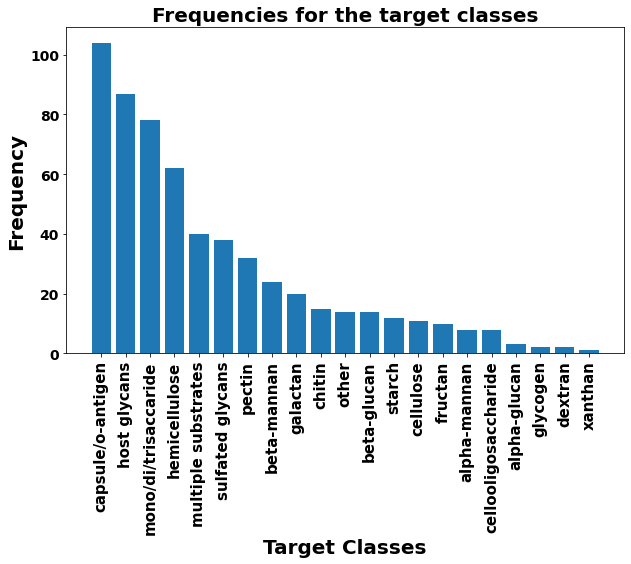

In [10]:
# define the plotting area
plt.figure(figsize = (10,6))
# need a bar plot
plt.bar(range(len(D)), list(D.values()), align='center')
# put the labels but rotate them
plt.xticks(range(len(D)), list(D.keys()), rotation = 90, weight = "bold")
# increase the ticks on y
plt.yticks(fontsize=14)
# give labels to x
plt.xlabel("Target Classes", weight = "bold", fontsize = 20)
# give labels to y
plt.ylabel("Frequency", weight = "bold", fontsize = 20)
# put the title
plt.title("Frequencies for the target classes", weight = "bold", fontsize = 20)
plt.show()

## What about the genes in the sequence?

In [11]:
# collect all the genes from each sequence
all_genes_per_sequence = [seq.split(",") for seq in data["sequence"]]
# loop over the list of genes and flatten it
all_genes = [gene for list_genes in all_genes_per_sequence for gene in list_genes]

In [12]:
# import numpy to deal with arrays
import numpy as np

In [13]:
# how many unique genes? 
len(np.unique(all_genes))

458

In [14]:
# import counter function
from collections import Counter

In [15]:
# get the frequency counts
freq_count = Counter(all_genes)

In [16]:
# sort in descending order
D =dict(sorted(freq_count.items(), key=lambda item: item[1], reverse = True))

In [17]:
# manipulate for plotting
first2pairs = {k: D[k] for k in list(D)}

In [18]:
# variable assignment
D = first2pairs

In [19]:
# some parameters for improved plotting aesthetics
mpl.rcParams['xtick.labelsize'] = 15 
plt.rcParams["font.weight"] = "bold"

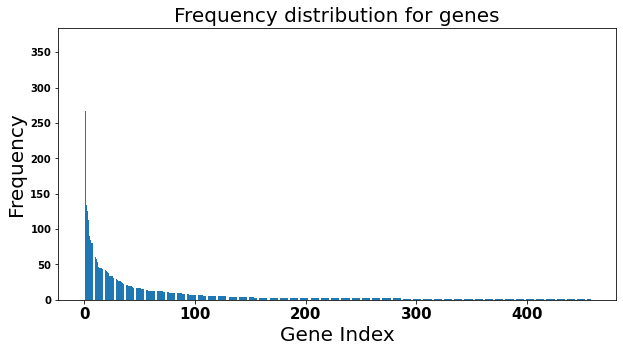

In [20]:
plt.figure(figsize = (10,5))
plt.bar(range(len(D)), list(D.values()), align='center')
plt.title("Frequency distribution for genes", fontsize = 20)
plt.xlabel("Gene Index", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()

In [21]:
# visualize the cdf
cdf_vec = np.cumsum(list(D.values()))/np.cumsum(list(D.values()))[-1]

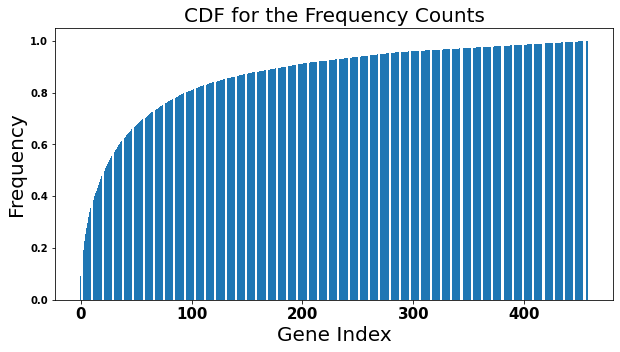

In [22]:
# make the plot for the cdf
plt.figure(figsize = (10,5))
plt.bar(range(len(cdf_vec)), cdf_vec, align='center')
plt.title("CDF for the Frequency Counts", fontsize = 20)
plt.xlabel("Gene Index", fontsize = 20)
plt.ylabel("Frequency", fontsize = 20)
plt.show()


# Prediction Models

## How many classes can we handle for greater than 80% accuracy?

In [23]:
# preprocessor
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# import the requisite packages
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier

In [25]:
# generic function that takes in the data and number of classes
def model_by_classes(num_classes, data): 
    # get the frequency counts
    all_classes = list(data.target.value_counts().keys())
    # suppose using the top 2
    keep_these_many = num_classes
    # top_k_classes
    top_k = all_classes[:keep_these_many]
    # not top two
    not_top_k = [target for target in all_classes if target not in top_k]
    # get the data for the top k classes
    top_k_data = data[data.target.isin(top_k)].reset_index(drop = True)
    # get the data for the non top_k classes
    not_top_k_data = data[data.target.isin(not_top_k)].reset_index(drop = True)
    # give the same label to all the targets of the not_top_k_data
    not_top_k_data["target"] = "unknown"
    # stack the top k and the not top k data together
    all_data = pd.concat([top_k_data, not_top_k_data], ignore_index = True)
    # instantiate the vectorizer again
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
    # pipeline
    clf = Pipeline([('countvectorizer',vectorizer),('rf',RandomForestClassifier(n_jobs = 6))])
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
    'countvectorizer__min_df': [1,2],
    'rf__n_estimators': [100,200,400], 
    'rf__max_features': ["auto", "log2"]
    }
    # fit the search
    search = GridSearchCV(clf, param_grid, n_jobs=7 , verbose = 3, cv = 5, scoring = "accuracy")
    # fir the grid search
    search.fit(all_data["sequence"], all_data["target"])
    # best score
    best_score = search.best_score_
    # std error
    std_accuracy = search.cv_results_['std_test_score'][np.argmax(search.cv_results_['mean_test_score'])]
    return num_classes, best_score, std_accuracy

In [26]:
# functions that can help us do parallel computation
from joblib import Parallel, delayed

In [27]:
# run the function in parallel
all_results = Parallel(n_jobs=7, verbose = 2)(delayed(model_by_classes)(i, data) for i in range(1, 10))

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   6 out of   9 | elapsed:   50.5s remaining:   25.2s
[Parallel(n_jobs=7)]: Done   9 out of   9 | elapsed:  1.2min finished


In [28]:
# get the error ranges
err_ranges = np.array(all_results)[:,2]*3

In [29]:
# put everything in a dataframe
df = pd.DataFrame(all_results)

In [30]:
# give column names
df.columns = ["num_classes", "mean_accuracy", "std_error_accuracy"]

In [31]:
# how much data do these classes cover
coverage = pd.DataFrame(data.target.value_counts().cumsum()/data.target.value_counts().cumsum()[-1])["target"].values[1:10]

In [32]:
# round the coverage
coverage = np.round(coverage,2).astype(str)

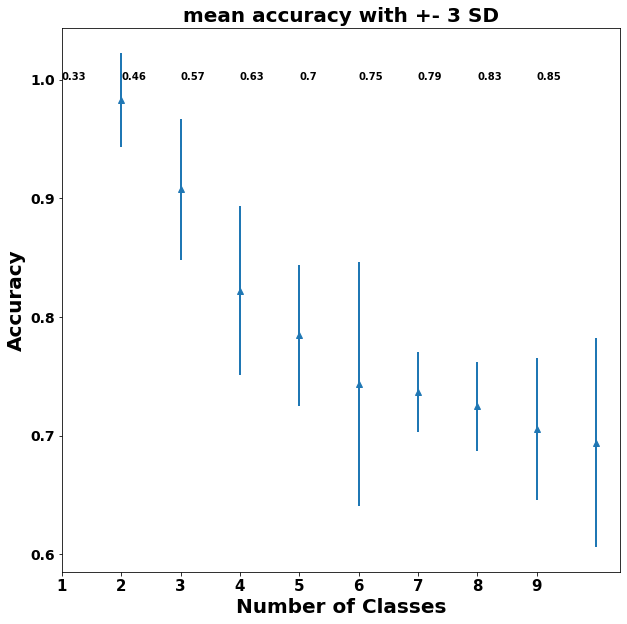

In [33]:
# create a plot
plt.figure(figsize = (10,10))
plt.errorbar(df["num_classes"] + 1,np.array(all_results)[:,1], 
             err_ranges, linestyle='None', marker='^', linewidth = 2)
plt.xlabel("Number of Classes", weight = "bold", fontsize = 20)
plt.ylabel("Accuracy", weight = "bold", fontsize = 20)
plt.yticks(fontsize=14)
plt.xticks(df["num_classes"])
counter = 1
plt.title("mean accuracy with +- 3 SD", weight = "bold", fontsize = 20)
for text in coverage: 
    plt.text(counter, 1, text)
    counter+=1
plt.show()

In [34]:
# make a new column for coverage
df["coverage"] = coverage

In [35]:
df

,num_classes,mean_accuracy,std_error_accuracy,coverage
0,1,0.982906,0.013241,0.33
1,2,0.907692,0.019788,0.46
2,3,0.822222,0.023809,0.57
3,4,0.784615,0.019788,0.63
4,5,0.743590,0.034188,0.7
5,6,0.736752,0.011339,0.75
6,7,0.724786,0.012561,0.79
7,8,0.705983,0.019935,0.83
8,9,0.694017,0.029310,0.85


We could decide to work with the top 3 most frequent classes because that model has an accuracy of over 80% but the issue is that the top 3 most frequent classes only cover about 57% of the data which I do not think is enough coverage. Therefore, I decide to work with the top six most frequent classes. The model for the top 6 most frequent classes has an accuracy of ~72% but covers 75% of the data. 

Therefore, the roadmap we will use is, we would have a classification model that can classify sequences into these top 6 most frequent classes. We would also have an unknown class in the mix which the model would classify a sequence into if it is not sure. 

## Implementing the roadmap

### RandomForest Supervised Learning Model

In [1]:
# import train test split
from sklearn.model_selection import train_test_split

In [126]:
# make a train and test set
X_train, X_test, y_train, y_test = train_test_split( data["sequence"], data["target"],
                                                    test_size=0.40, random_state=42)

In [127]:
# generic function that takes in the data and number of classes
def model_by_classes_train(num_classes, data): 
    # get the frequency counts
    all_classes = list(data.target.value_counts().keys())
    # suppose using the top 2
    keep_these_many = num_classes
    # top_k_classes
    top_k = all_classes[:keep_these_many]
    # not top two
    not_top_k = [target for target in all_classes if target not in top_k]
    # get the data for the top k classes
    top_k_data = data[data.target.isin(top_k)].reset_index(drop = True)
    # get the data for the non top_k classes
    not_top_k_data = data[data.target.isin(not_top_k)].reset_index(drop = True)
    # give the same label to all the targets of the not_top_k_data
    not_top_k_data["target"] = "unknown"
    # stack the top k and the not top k data together
    all_data = pd.concat([top_k_data, not_top_k_data], ignore_index = True)
    # instantiate the vectorizer again
    vectorizer = CountVectorizer(tokenizer=lambda x: x.split(','))
    # pipeline
    clf = Pipeline([('countvectorizer',vectorizer),('rf',RandomForestClassifier(n_jobs = 6, class_weights = "balanced_subsample"))])
    # Parameters of pipelines can be set using ‘__’ separated parameter names:
    param_grid = {
    'countvectorizer__min_df': [1,2],
    'rf__n_estimators': [100,200,400], 
    'rf__max_features': ["auto", "log2"]
    }
    # fit the search
    search = GridSearchCV(clf, param_grid, n_jobs=7 , verbose = 3, cv = 5, scoring = "accuracy")
    # fir the grid search
    search.fit(all_data["sequence"], all_data["target"])
    # best score
    best_score = search.best_score_
    # std error
    std_accuracy = search.cv_results_['std_test_score'][np.argmax(search.cv_results_['mean_test_score'])]
    return num_classes, best_score, std_accuracy, search.best_estimator_, top_k, not_top_k

In [128]:
data_train = pd.concat([pd.DataFrame(X_train.values), pd.DataFrame(y_train.values)], ignore_index = True, axis = 1)

In [129]:
data_train.columns = ["sequence", "target"]

In [130]:
# use the function with 6 classes and only train data
num_classes, best_score, std_accuracy, best_estimator_, top_k, not_top_k = model_by_classes_train(6, data_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [131]:
# best score and std error
best_score, std_accuracy

(0.6951307847082495, 0.02673116795220182)

In [132]:
best_estimator = best_estimator_

In [133]:
# column change the original targets to top 6 + unknown
targets_train = [target if target in top_k else "unknown" for target in data_train["target"]]

In [134]:
# refit this best estimator
best_estimator.fit(data_train["sequence"], targets_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=2,
                                 tokenizer=<function model_by_classes_train.<locals>.<lambda> at 0x00000228B1AB00D0>)),
                ('rf', RandomForestClassifier(n_jobs=6))])

In [135]:
# get the predictions for test
y_test_pred = best_estimator.predict(X_test)

In [136]:
# get the confusion matrix 

In [137]:
from sklearn.metrics import confusion_matrix

In [138]:
data_test = pd.concat([pd.DataFrame(X_test.values), pd.DataFrame(y_test.values)], ignore_index = True, axis = 1)

In [139]:
data_test.columns = ["sequence", "target"]

In [140]:
# column change the original targets to top 6 + unknown
targets_test = [target if target in top_k else "unknown" for target in data_test["target"]]

In [141]:
# get the array oaf confusion matrix
cm = confusion_matrix(targets_test, y_test_pred)

In [142]:
# dataframe for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in best_estimator.classes_],
                  columns = [i for i in best_estimator.classes_])

In [143]:
# seaborn that helps with aesthetically pleasing plots
import seaborn as sns

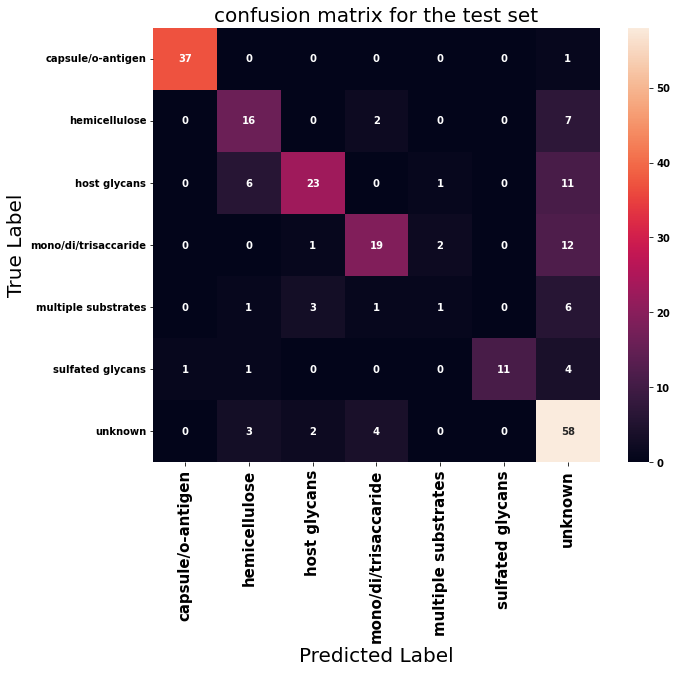

In [144]:
# make the plot
plt.figure(figsize = (10, 8))
sns.heatmap(df_cm, annot = True)
plt.title("confusion matrix for the test set", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)
plt.ylabel("True Label", fontsize = 20)
plt.show()


In [145]:
from sklearn.metrics import accuracy_score

In [146]:
accuracy_score(targets_test, y_test_pred)

0.7051282051282052

So far, we have a trained random forest classifier which can classify new sequences into the top 6 most frequent classes and an unknown class if it is not sure.

### Few Shot Learning

**High Level Goal** - We will handle the classes we lumped in the unknown class using few shot learning. 

In [147]:
# unknown classes
not_top_k

['beta-mannan',
 'pectin',
 'beta-glucan',
 'galactan',
 'cellulose',
 'cellooligosaccharide',
 'chitin',
 'starch',
 'other',
 'alpha-mannan',
 'fructan',
 'alpha-glucan',
 'glycogen',
 'dextran',
 'xanthan']

In [148]:
# get those data from the train data
not_top_k_data_train = data_train[data_train.target.isin(not_top_k)].reset_index(drop = True)

In [149]:
not_top_k_data_train.head()

,sequence,target
0,"4.A.3,4.A.3,4.A.3,8.A.49,GntR,GH26",beta-mannan
1,"GH5,1.B.14,GH5,GH2,GH5,GH140,GH130,2.A.2,GH78|CBM67",other
2,"Pyr_redox_2,GH13|CBM48,GT5,GT35,CBM34|GH13,3.A.1",glycogen
3,"1.B.14,GH30,GH3",beta-glucan
4,"GH16|GH0,GH3,SIS+SIS,GntR,1.A.30,1.A.30,1.B.14",chitin


In [150]:
# shape
not_top_k_data_train.shape

(109, 2)

In [151]:
not_top_k_data_train["target"].value_counts()

beta-mannan             18
pectin                  16
beta-glucan             11
galactan                10
cellulose                9
chitin                   8
cellooligosaccharide     8
starch                   7
other                    6
alpha-mannan             5
fructan                  5
alpha-glucan             3
glycogen                 1
dextran                  1
xanthan                  1
Name: target, dtype: int64

In [152]:
# get those data from the test data
not_top_k_data_test = data_test[data_test.target.isin(not_top_k)].reset_index(drop = True)

In [153]:
not_top_k_data_test.head()

,sequence,target
0,"GH3,HTH_AraC,GH16,1.B.14,8.A.46,GH3",beta-glucan
1,"GH130,LacI,GH130,SBP_bac_1,GH27,3.A.1,3.A.1,CE7",beta-mannan
2,"8.A.9,CBM34|GH13,3.A.1,3.A.1,3.A.1",other
3,"GH1,HTH_6+SIS,3.A.1,8.A.59,Response_reg+HTH_18+HTH_AraC,3.A.1,3.A.1,3.A.1",galactan
4,"LacI,1.B.3,GH42,GH53,3.A.1,3.A.1,3.A.1,3.A.1",galactan


In [154]:
# shape
not_top_k_data_test.shape

(67, 2)

In [155]:
from metric_learn import NCA

In [156]:
from sklearn.preprocessing import FunctionTransformer

In [157]:
# classifier again
clf = Pipeline([('countvectorizer', CountVectorizer(tokenizer=lambda x: x.split(','))),
                ('ft', FunctionTransformer(lambda x: x.toarray(), accept_sparse=True)), 
                ('nca', NCA()),
                ('rf', RandomForestClassifier(n_jobs = 6))])

In [158]:
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'countvectorizer__min_df': [1,2,3],
    'rf__n_estimators': [100,200,400], 
    'rf__max_features': ["auto", "log2"]
}

In [159]:
# fit the search
search = GridSearchCV(clf, param_grid, n_jobs=6 , verbose = 3, cv = 5, scoring = "accuracy")
search.fit(not_top_k_data_train["sequence"], not_top_k_data_train["target"])

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\vedpi\anaconda3\envs\newone\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer',
                                        CountVectorizer(tokenizer=<function <lambda> at 0x00000228B1343310>)),
                                       ('ft',
                                        FunctionTransformer(accept_sparse=True,
                                                            func=<function <lambda> at 0x00000228B14BD790>)),
                                       ('nca', NCA()),
                                       ('rf',
                                        RandomForestClassifier(n_jobs=6))]),
             n_jobs=6,
             param_grid={'countvectorizer__min_df': [1, 2, 3],
                         'rf__max_features': ['auto', 'log2'],
                         'rf__n_estimators': [100, 200, 400]},
             scoring='accuracy', verbose=3)

In [160]:
# mean average accuracy
search.best_score_

0.5593073593073592

In [161]:
# standard error
search.cv_results_['std_test_score'][np.argmax(search.cv_results_['mean_test_score'])]

0.06971713294960137

In [162]:
# best parameters
search.best_params_

{'countvectorizer__min_df': 3,
 'rf__max_features': 'log2',
 'rf__n_estimators': 100}

In [163]:
# get the best estimator
best_estimator = search.best_estimator_

In [164]:
# fit again
best_estimator.fit(not_top_k_data_train["sequence"], not_top_k_data_train["target"])

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=3,
                                 tokenizer=<function <lambda> at 0x00000228B1343310>)),
                ('ft',
                 FunctionTransformer(accept_sparse=True,
                                     func=<function <lambda> at 0x00000228B14BD790>)),
                ('nca', NCA()),
                ('rf', RandomForestClassifier(max_features='log2', n_jobs=6))])

In [165]:
# predicitions on test
y_test_pred = best_estimator.predict(not_top_k_data_test["sequence"])

In [166]:
# get the array of confusion matrix
cm = confusion_matrix(not_top_k_data_test["target"], y_test_pred)

In [168]:
# which is the missing class
missing_classes = [classes for classes in best_estimator.classes_ if classes not in np.unique(not_top_k_data_test["target"])]

missing_classes

['alpha-glucan', 'cellooligosaccharide', 'xanthan']

In [169]:
# dataframe for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in best_estimator.classes_ if i not in missing_classes],
                  columns = [i for i in best_estimator.classes_ if i not in missing_classes])

ValueError: Shape of passed values is (14, 14), indices imply (12, 12)

In [ ]:
# make the plot
plt.figure(figsize = (10, 8))
sns.heatmap(df_cm, annot = True)
plt.title("confusion matrix for the test set", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)
plt.ylabel("True Label", fontsize = 20)
plt.show()


In [ ]:
## get the accuracy

In [ ]:
accuracy_score(not_top_k_data_test["target"], y_test_pred)

### Maybe another random forest for the unknowns?

In [ ]:
clf = Pipeline([('countvectorizer',CountVectorizer(tokenizer=lambda x: x.split(','))),
                ('rf',RandomForestClassifier(n_jobs = 6))])
# Parameters of pipelines can be set using ‘__’ separated parameter names:
param_grid = {
    'countvectorizer__min_df': [1,2],
    'rf__n_estimators': [100,200,400], 
    'rf__max_features': ["auto", "log2"]
}
# fit the search
search = GridSearchCV(clf, param_grid, n_jobs=7 , verbose = 3, cv = 5, scoring = "accuracy")
# fir the grid search
search.fit(not_top_k_data_train["sequence"], not_top_k_data_train["target"])

In [ ]:
# mean average accuracy
search.best_score_

In [ ]:
# standard error
search.cv_results_['std_test_score'][np.argmax(search.cv_results_['mean_test_score'])]

In [ ]:
# best parameters
search.best_params_

In [ ]:
# get the best estimator
best_estimator = search.best_estimator_

In [ ]:
# fit again
best_estimator.fit(not_top_k_data_train["sequence"], not_top_k_data_train["target"])

In [ ]:
# predicitions on test
y_test_pred = best_estimator.predict(not_top_k_data_test["sequence"])

In [ ]:
# get the array of confusion matrix
cm = confusion_matrix(not_top_k_data_test["target"], y_test_pred)

In [ ]:
# in train there was one more class than the test
best_estimator.classes_

In [ ]:
# which is the missing class
missing_classes = [classes for classes in best_estimator.classes_ if classes not in np.unique(not_top_k_data_test["target"])]

In [ ]:
missing_classes

In [ ]:
# dataframe for confusion matrix
df_cm = pd.DataFrame(cm, index = [i for i in best_estimator.classes_ if i not in missing_classes],
                  columns = [i for i in best_estimator.classes_ if i not in missing_classes] )

In [ ]:
# make the plot
plt.figure(figsize = (10, 8))
sns.heatmap(df_cm, annot = True)
plt.title("confusion matrix for the test set", fontsize = 20)
plt.xlabel("Predicted Label", fontsize = 20)
plt.ylabel("True Label", fontsize = 20)
plt.show()


In [ ]:
## get the accuracy

In [ ]:
accuracy_score(not_top_k_data_test["target"], y_test_pred)

### Metric Learning and MDS